In [90]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")  #Ignore the warnings
from sklearn import preprocessing
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt  
from sklearn.metrics  import roc_curve
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

In [91]:
train = pd.read_csv('train_s3TEQDk.csv')
test =  pd.read_csv('test_mSzZ8RL.csv')

In [92]:
# Count the number of missing values in each column
train.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

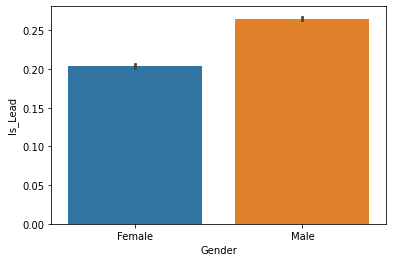

In [93]:
sns.barplot(x=train.Gender,y=train['Is_Lead']);

In [94]:
train.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


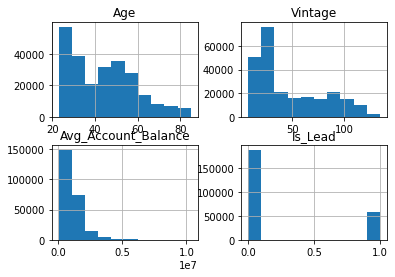

In [95]:
train.hist();

In [96]:
# modes of categorical values
print(train['Credit_Product'].mode())
print(test['Credit_Product'].mode())

0    No
dtype: object
0    No
dtype: object


In [97]:
# Fill the missing categorical values with mode
train['Credit_Product'].fillna(str(train['Credit_Product'].mode().values[0]),inplace=True)
test['Credit_Product'].fillna(str(test['Credit_Product'].mode().values[0]),inplace=True)

In [98]:
train.isnull().sum()

ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
Is_Lead                0
dtype: int64

In [99]:
train_categorical = train.select_dtypes(include=['object'])
test_categorical = test.select_dtypes(include=['object'])
train_categorical

,ID,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active
0,NNVBBKZB,Female,RG268,Other,X3,No,No
1,IDD62UNG,Female,RG277,Salaried,X1,No,No
2,HD3DSEMC,Female,RG268,Self_Employed,X3,No,Yes
3,BF3NC7KV,Male,RG270,Salaried,X1,No,No
4,TEASRWXV,Female,RG282,Salaried,X1,No,No
...,...,...,...,...,...,...,...
245720,BPAWWXZN,Male,RG284,Self_Employed,X3,No,No
245721,HFNB7JY8,Male,RG268,Salaried,X1,No,Yes
245722,GEHAUCWT,Female,RG281,Salaried,X1,No,No
245723,GE7V8SAH,Female,RG273,Salaried,X1,No,No


In [100]:
train_categorical.drop(['ID'],axis=1,inplace=True)
test_categorical.drop(['ID'],axis=1,inplace=True)
train_categorical.head()

,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active
0,Female,RG268,Other,X3,No,No
1,Female,RG277,Salaried,X1,No,No
2,Female,RG268,Self_Employed,X3,No,Yes
3,Male,RG270,Salaried,X1,No,No
4,Female,RG282,Salaried,X1,No,No


In [101]:
le = preprocessing.LabelEncoder()
train_categorical = train_categorical.apply(le.fit_transform)
test_categorical = test_categorical.apply(le.fit_transform)
train_categorical.head()

,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active
0,0,18,1,2,0,0
1,0,27,2,0,0,0
2,0,18,3,2,0,1
3,1,20,2,0,0,0
4,0,32,2,0,0,0


In [102]:
train = train.drop(train.select_dtypes(include=['object']), axis=1)
train = pd.concat([train,train_categorical], axis=1)
test = test.drop(test.select_dtypes(include=['object']), axis=1)
test = pd.concat([test,test_categorical], axis=1)
train.head()

,Age,Vintage,Avg_Account_Balance,Is_Lead,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active
0,73,43,1045696,0,0,18,1,2,0,0
1,30,32,581988,0,0,27,2,0,0,0
2,56,26,1484315,0,0,18,3,2,0,1
3,34,19,470454,0,1,20,2,0,0,0
4,30,33,886787,0,0,32,2,0,0,0


In [103]:
test

,Age,Vintage,Avg_Account_Balance,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active
0,29,25,742366,1,4,1,0,1,0
1,43,49,925537,1,18,1,1,0,0
2,31,14,215949,1,20,2,0,0,0
3,29,33,868070,1,22,1,0,0,0
4,29,19,657087,0,20,1,0,0,0
...,...,...,...,...,...,...,...,...,...
105307,52,86,4242558,1,18,2,1,1,1
105308,55,86,1159153,1,27,1,1,1,0
105309,35,15,1703727,1,4,2,3,0,0
105310,53,93,737178,1,4,1,2,0,1


In [104]:
train['Is_Lead'] = train['Is_Lead'].astype('category')

In [105]:
#For train dataset
train_x = train.drop('Is_Lead',axis=1)
train_y = train['Is_Lead']

In [106]:
train_x.shape,train_y.shape

((245725, 9), (245725,))

In [107]:
train.columns

Index(['Age', 'Vintage', 'Avg_Account_Balance', 'Is_Lead', 'Gender',
       'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product',
       'Is_Active'],
      dtype='object')

In [108]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_x['Age']=scaler.fit_transform(train_x[['Age']])
train_x['Vintage']=scaler.fit_transform(train_x[['Vintage']])
train_x['Avg_Account_Balance']=scaler.fit_transform(train_x[['Avg_Account_Balance']])
train_x['Gender']=scaler.fit_transform(train_x[['Gender']])
train_x['Region_Code']=scaler.fit_transform(train_x[['Region_Code']])
train_x['Occupation']=scaler.fit_transform(train_x[['Occupation']])
train_x['Channel_Code']=scaler.fit_transform(train_x[['Channel_Code']])
train_x['Credit_Product']=scaler.fit_transform(train_x[['Credit_Product']])
train_x['Is_Active']=scaler.fit_transform(train_x[['Is_Active']])
train_x

,Age,Vintage,Avg_Account_Balance,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active
0,1.965365,-0.122373,-0.096968,-1.096931,-0.172389,-1.292279,1.239925,-0.644048,-0.796872
1,-0.934429,-0.462372,-0.640630,-1.096931,0.655830,-0.120975,-1.020375,-0.644048,-0.796872
2,0.818935,-0.647825,0.417279,-1.096931,-0.172389,1.050330,1.239925,-0.644048,1.254906
3,-0.664680,-0.864188,-0.771395,0.911634,0.011660,-0.120975,-1.020375,-0.644048,-0.796872
4,-0.934429,-0.431463,-0.283276,-1.096931,1.115951,-0.120975,-1.020375,-0.644048,-0.796872
...,...,...,...,...,...,...,...,...,...
245720,0.481750,1.917619,0.934635,0.911634,1.300000,1.050330,1.239925,-0.644048,-0.796872
245721,-1.136740,-0.987824,-0.311221,0.911634,-0.172389,-0.120975,-1.020375,-0.644048,1.254906
245722,-1.204177,-1.049642,-0.536670,-1.096931,1.023927,-0.120975,-1.020375,-0.644048,-0.796872
245723,-1.069303,-0.493281,-0.845199,-1.096931,0.287733,-0.120975,-1.020375,-0.644048,-0.796872


In [109]:
def cross_val(X, y, model, params, folds=9):

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=21)
    for fold, (train_idx, test_idx) in enumerate(skf.split(train_x, train_y)):
        print(f"Fold: {fold}")
        x_train, y_train = train_x.iloc[train_idx], train_y.iloc[train_idx]
        x_test, y_test = train_x.iloc[test_idx], train_y.iloc[test_idx]

        alg = model(**params)
        alg.fit(x_train, y_train,
                eval_set=[(x_test, y_test)],
                early_stopping_rounds=100,
                verbose=400)

        pred = alg.predict_proba(x_test)[:, 1]
        roc_score = roc_auc_score(y_test, pred)
        print(f"roc_auc_score: {roc_score}")
        print("-"*50)
    
    return alg
    

In [110]:
xgb_params= {'n_estimators': 20000, 
             'max_depth': 6, 
             'learning_rate': 0.045, 
             'reg_lambda': 29.326, 
             'subsample': 0.818, 
             'colsample_bytree': 0.235, 
             'colsample_bynode': 0.820, 
             'colsample_bylevel': 0.453}

In [111]:
from xgboost import XGBClassifier
xgb_model = cross_val(train_x, train_y, XGBClassifier, xgb_params)

Fold: 0
[0]	validation_0-error:0.23719
Will train until validation_0-error hasn't improved in 100 rounds.
Stopping. Best iteration:
[1]	validation_0-error:0.219573

roc_auc_score: 0.720667337348627
--------------------------------------------------
Fold: 1
[0]	validation_0-error:0.235798
Will train until validation_0-error hasn't improved in 100 rounds.
Stopping. Best iteration:
[1]	validation_0-error:0.218914

roc_auc_score: 0.7148666906907706
--------------------------------------------------
Fold: 2
[0]	validation_0-error:0.236091
Will train until validation_0-error hasn't improved in 100 rounds.


KeyboardInterrupt: ignored

In [ ]:
final_preds = xgb_model.predict(test)

In [ ]:
#make submission for kaggle 
pid = pd.read_csv('test_mSzZ8RL.csv')
pid = pid['ID'].values
pid

In [ ]:
out_df = pd.DataFrame({'ID' : pid,'Is_Lead': final_preds})
out_df.head()

In [ ]:
out_df.to_csv('submission.csv', index=False)

In [ ]:
out_df.shape